## Tutorial 2: Integrating datasets measured by different platforms.        
In this tutorial, we demonstrate how to apply Spatialign to integrate datasets that were measured by different platforms. As an example, we used three mouse olfactory bulb datasets. One slice was profiled by 10x Genomics Visium, while the other two slices were obtained from Stereo-seq. 

- ### Import packages

In [1]:
import scanpy as sc
from spatialign import Spatialign
from warnings import filterwarnings
from anndata import AnnData

filterwarnings("ignore")

In [2]:
datasets = [
    "stereo_olfactory_bulb_ann.h5ad",
    "visium_olfactory_bulb_ann.h5ad",
    "stereo_ob_SS200000213BR_C5_bin200_ann.h5ad"
]

- ### Initialize              

     Read datasets and load Spatialign model

In [3]:
model = Spatialign(
    *datasets,
    batch_key='batch',
    is_norm_log=True,
    is_scale=False,
    n_neigh=15,
    is_undirected=True,
    latent_dims=100,
    seed=42,
    gpu=0,
    save_path="./",
    is_verbose=False
)

2023-07-20 18:18:32 Found Dataset: 
  cell nums: 1123 gene nums: 20317
  cell nums: 1184 gene nums: 13956
  cell nums: 812 gene nums: 16370
2023-07-20 18:18:33: Spatial coordinates are used to calculate nearest neighbor graphs
2023-07-20 18:18:38 Method: 'init_bank' Running...
  Running time: 0.0 min 1.0062 s


- ### Visualization original dataset by UMAP

In [4]:
raw_merge = AnnData.concatenate(*model.dataset.data_list)

In [5]:
sc.tl.pca(raw_merge, n_comps=100, random_state=42)
sc.pp.neighbors(raw_merge, random_state=42)
sc.tl.umap(raw_merge, random_state=42)

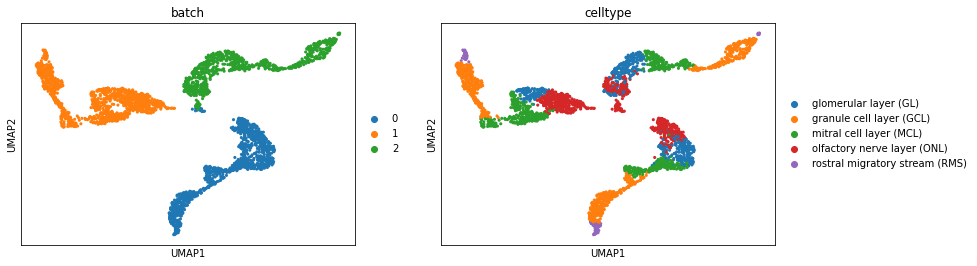

In [6]:
sc.pl.umap(raw_merge, color=["batch", "celltype"])

- ### Training Spatialign model     

     Spatialign aims to aligns the biological effects, while maximized preserving spots/cells biological variances in the latent embedding.        
      
    It is possible to fine-tune the parameters (tau1, tau2, tau3) to optimize the model's performance.

In [7]:
model.train(tau1=0.05, tau2=1, tau3=0.1)

2023-07-20 18:20:43 Method: 'train' Running...
  2023-07-20 18:21:30 Epoch: 123 Loss: 21.9860 Loss min: 21.9455 EarlyStopping counter: 15 out of 15
  2023-07-20 18:21:30 Model Training Finished!
  2023-07-20 18:21:30 Trained checkpoint file has been saved to ./ckpt
  Running time: 0.0 min 46.6752 s


- ### Inference alignment datasets      
    
     After model training, the learned lower-dimensional representations will be saved in adata.obsm['correct'], and the higher-dimensional representations will be saved in adata.X

In [8]:
model.alignment()

2023-07-20 18:21:30 Method: 'alignment' Running...
2023-07-20 18:21:33 Batch Alignment Finished!
2023-07-20 18:21:33 Alignment data saved in: ./res
  Running time: 0.0 min 3.3786 s


- ### Validation inference datasets

In [9]:
correct1 = sc.read_h5ad("./res/correct_data0.h5ad")
correct2 = sc.read_h5ad("./res/correct_data1.h5ad")
correct3 = sc.read_h5ad("./res/correct_data2.h5ad")

In [10]:
merge_data = correct1.concatenate(correct2, correct3)

In [11]:
sc.pp.neighbors(merge_data, use_rep="correct", random_state=42)
sc.tl.umap(merge_data, random_state=42)

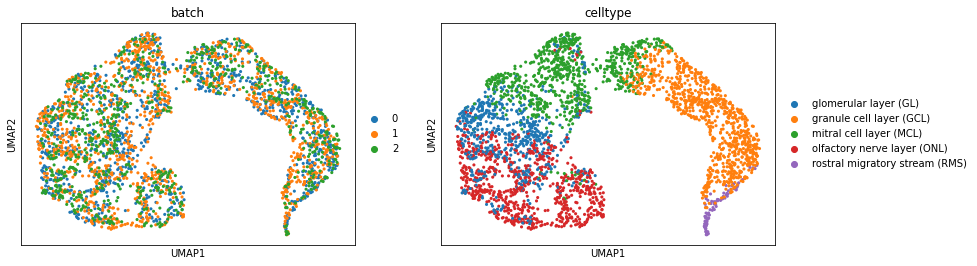

In [12]:
sc.pl.umap(merge_data, color=["batch", "celltype"])